## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [34]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib
import matplotlib.pylab as plt
import IPython.display as ipd
import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence, normalize_text
from denoiser import Denoiser

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# !pip install denoiser

In [35]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

In [36]:
def plot_specs(spec):
    plt.imshow(spec, aspect='auto', origin='bottom', interpolation='none')
    plt.show()

#### Decode text input and plot results

In [31]:
from denoiser import Denoiser
from glow import *

%load_ext autoreload
%autoreload 2

hparams = create_hparams(language='vn', is_cuda=True)

if hparams.is_cuda:
    device = "cuda"
else:
    device = "cpu"

waveglow_path = '/home/nguyen.thanh.trungb/Desktop/TTS_Project/outdir/waveglow_256channels.pt'
waveglow = torch.load(waveglow_path, map_location=torch.device(device))['model']

for m in waveglow.modules():
    if 'Conv' in str(type(m)):
        setattr(m, 'padding_mode', 'zeros')

for k in waveglow.convinv:
    k.float()


if hparams.is_cuda:
    waveglow.cuda()
else:
    waveglow.cpu()
    
denoiser = Denoiser(waveglow, is_cuda=hparams.is_cuda)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### (Optional) Remove WaveGlow bias

In [72]:
import re




def split_corpus(corpus):
    corpus = re.sub("\s+", " ", corpus)
    result = []
    max_len = 10
    
    sents = re.split('\.|:|\?|!|…', corpus)
    for sent in sents:
        if sent:
            if len(sent.split(" ")) < max_len:
                result.append([sent])
            else:
                result.append(split_sent(sent))
    return result

def split_sent(sent):
    result = []
    min_len = 5
    subsents = re.split(',|;', sent)
    current_sent = subsents[0]
    
    for i, subsent in enumerate(subsents[1:]):
        if subsent:
            if len(current_sent.split(" ")) < min_len:
                current_sent = " , ".join([current_sent,subsent])
            else:
    #             current_sent = normalize_text(current_sent, language="vn")
                result.append(current_sent)
                current_sent = subsent

    result.append(current_sent)
    return result

def tts(text, model ,show_mel=False, hparams=hparams, denoiser=denoiser, waveglow=waveglow):
    sequence = np.array(text_to_sequence(text, ['basic_cleaners'], language=hparams.language))[None, :]
    sequence = torch.autograd.Variable(torch.from_numpy(sequence))
    if hparams.is_cuda:
        sequence = sequence.cuda().long()
    else:
        sequence = sequence.cpu().long()

    mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
    if show_mel is True:
        plot_specs(mel_outputs_postnet.float().data.cpu().numpy()[0])
    with torch.no_grad():
        audio = waveglow.infer(mel_outputs_postnet, is_cuda=hparams.is_cuda, sigma=0.666)
    audio_denoised = denoiser(audio, strength=0.01)[:, 0]
    audio_denoised = audio_denoised.cpu().numpy()
    audio_denoised, index = librosa.effects.trim(audio_denoised, top_db=20)
    return audio_denoised



def pts(para, model ,show_mel=False, hparams=hparams, denoiser=denoiser, waveglow=waveglow):
    audio = np.zeros((1,0))
    sents = split_corpus(para)

    for sent in sents:
        for sub_sent in sent:
            speech = tts(sub_sent.strip(), model=model,
                         show_mel=show_mel, hparams=hparams,
                         denoiser=denoiser, waveglow=waveglow)
            audio = np.append(audio, speech, axis=1)
            audio = np.append(audio, np.zeros((1, int(hparams.sampling_rate/6)), dtype=np.uint8) , axis=1)
        audio = np.append(audio, np.zeros((1, int(hparams.sampling_rate/3)), dtype=np.uint8) , axis=1)
    return audio

In [42]:
import os

checkpoint_path = "/home/nguyen.thanh.trungb/Desktop/TTS_Project/tacotron2/outdir/checkpoint_13650_0_3582060005929735"
model = Tacotron2(hparams)
if hparams.is_cuda:
    _ = model.cuda().eval()
else:
    _ = model.cpu().eval()

model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device(device))['state_dict'])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [38]:


# sequence = np.array(text_to_sequence(text, ['basic_cleaners'], language=hparams.language))[None, :]
# sequence = torch.autograd.Variable(torch.from_numpy(sequence))
# if hparams.is_cuda:
#     sequence = sequence.cuda().long()
# else:
#     sequence = sequence.cpu().long()

# mel_outputs, mel_outputs_postnet, gate, alignments = model.inference(sequence)
# plot_specs(mel_outputs_postnet.float().data.cpu().numpy()[0])



In [39]:
# with torch.no_grad():
#     audio = waveglow.infer(mel_outputs_postnet, is_cuda=hparams.is_cuda, sigma=0.666)
# audio_denoised = denoiser(audio, strength=0.01)[:, 0].cpu().numpy()
# ipd.Audio(audio_denoised, rate=hparams.sampling_rate)

[['Dù chưa biết mặt mũi mẹ con ra sao', ' nhưng ba có nghe qua thầy bói nói là mẹ con tuổi hợi', ' dịu dàng ,  xinh đẹp và nấu ăn rất ngon'], [' Vậy là ba con mình chắc nịch mảng ăn ngon mặc ấm rồi con nhỉ'], [' Con hẳn sẽ thừa hưởng những nét đẹp đó của mẹ', ' cùng trái tim nhân hậu của bà nội và tinh thần lạc quan của ông nội'], [' Lúc đó ,  con', ' mẹ và bà nội sẽ là 3 người phụ nữ đẹp nhất thế giới', ' ít nhất là đối với ba và ông nội']]
normalize_text  -- dù chưa biết mặt_mũi mẹ con ra sao ..


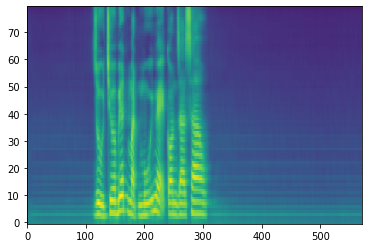

normalize_text  -- nhưng ba có nghe qua thầy_bói nói là mẹ_con tuổi hợi ..


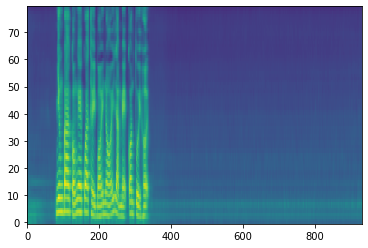

normalize_text  -- dịu_dàng , xinh_đẹp và nấu_ăn rất ngon ..
Warning! Reached max decoder steps


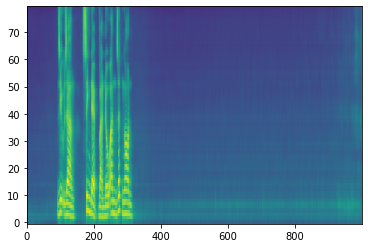

normalize_text  -- vậy là ba con mình chắc_nịch mảng ăn ngon mặc ấm rồi con nhỉ ..


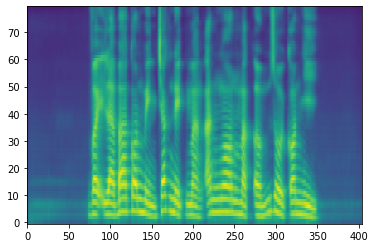

normalize_text  -- con hẳn sẽ thừa_hưởng những nét đẹp đó của mẹ ..


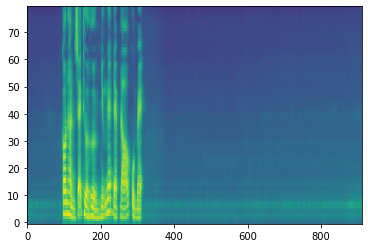

normalize_text  -- cùng trái_tim nhân_hậu của bà nội và tinh_thần lạc_quan của ông nội ..


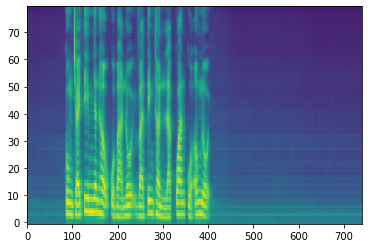

normalize_text  -- lúc đó , con ..


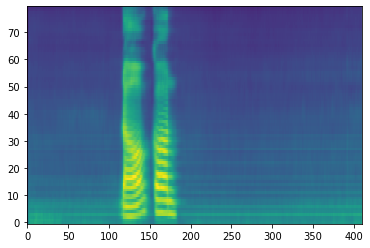

normalize_text  -- mẹ và bà nội sẽ là ba người phụ_nữ đẹp nhất thế_giới ..


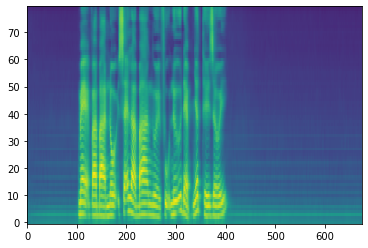

normalize_text  -- ít nhất là đối_với ba và ông nội ..


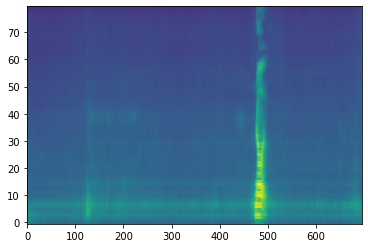

In [79]:
import librosa

corpus = "Dù chưa biết mặt mũi mẹ con ra sao, nhưng ba có nghe qua thầy bói nói là mẹ con tuổi hợi, dịu dàng, xinh đẹp và nấu ăn rất ngon. Vậy là ba con mình chắc nịch mảng ăn ngon mặc ấm rồi con nhỉ? Con hẳn sẽ thừa hưởng những nét đẹp đó của mẹ, cùng trái tim nhân hậu của bà nội và tinh thần lạc quan của ông nội. Lúc đó, con, mẹ và bà nội sẽ là 3 người phụ nữ đẹp nhất thế giới, ít nhất là đối với ba và ông nội."
print(split_corpus(corpus))
audio = pts(corpus, model=model, hparams=hparams, waveglow=waveglow, denoiser=denoiser, show_mel=True)
ipd.Audio(audio, rate=hparams.sampling_rate) 

In [48]:
# audio_denoised = denoiser(audio, strength=0.01)[:, 0].cpu().numpy()
ipd.Audio(audio, rate=hparams.sampling_rate)